In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm

In [29]:
# Set colours for plots
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Plot causal graph given adjacency matrix
def plot_graph(input_graph):
    
    graph = nx.DiGraph(input_graph)

    plt.figure(figsize=(8, 8))
    nx.draw(
    G=graph,
    node_color=COLORS[0],
    node_size=10000,
    arrowsize=17,
    with_labels=True,
    labels=node_lookup,
    font_color='white',
    font_size=9,
    pos=nx.circular_layout(graph)
    )

In [74]:
# Create node lookup for channels
node_lookup = {0: 'demand',
    1: 'tv spend',
    2: 'social spend',                
    3: 'social clicks',
    4: 'paid search imps',
    5: 'paid search clicks',
    6: 'organic search imps',    
    7: 'organic search clicks',
    8: 'sign ups'                                                                             
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the basis for our known graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create known graph using expert domain knowledge
graph_actual[0, 4] = 1.0 # demand -> paid search imps
graph_actual[0, 6] = 1.0 # demand -> organic search imps
graph_actual[0, 8] = 1.0 # demand -> signups

graph_actual[1, 4] = 1.0 # tv spend -> paid search imps
graph_actual[1, 6] = 1.0 # tv spend -> organic search imps

graph_actual[2, 3] = 1.0 # social spend -> social clicks
graph_actual[2, 4] = 1.0 # social spend -> paid search imps
graph_actual[2, 6] = 1.0 # social spend -> organic search imps

graph_actual[3, 8] = 1.0 # social clicks -> signups

graph_actual[4, 5] = 1.0 # paid search imps -> paid search clicks
graph_actual[4, 6] = 1.0 # paid search imps -> organic search imps

graph_actual[5, 8] = 1.0 # paid search clicks -> signups

graph_actual[6, 7] = 1.0 # organic search imps -> organic clicks

graph_actual[7, 8] = 1.0 # organic clicks -> signups

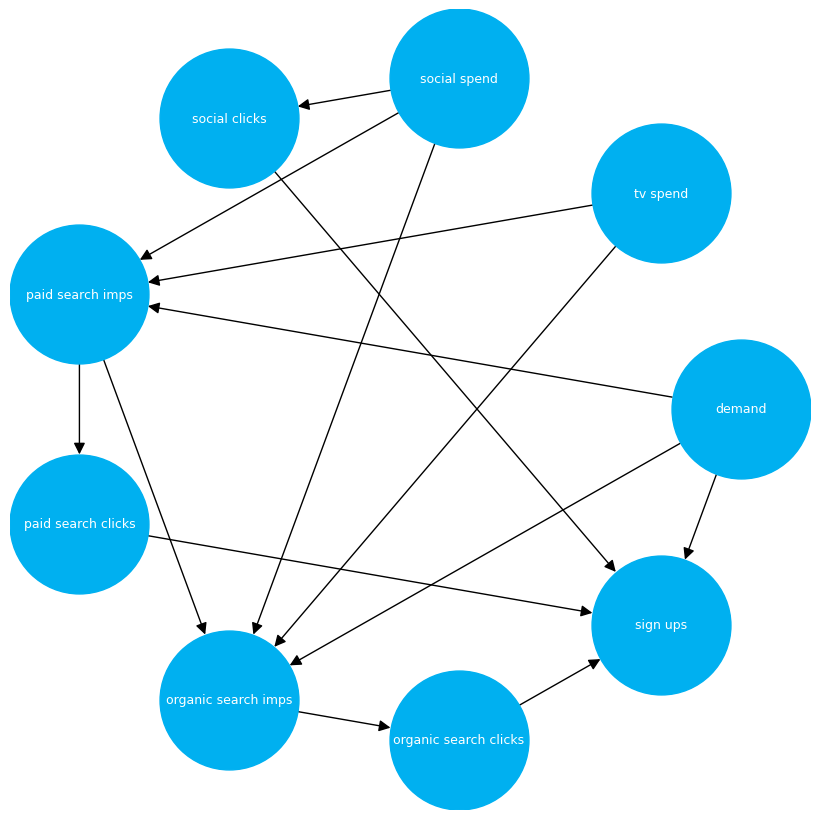

In [75]:
plot_graph(graph_actual)

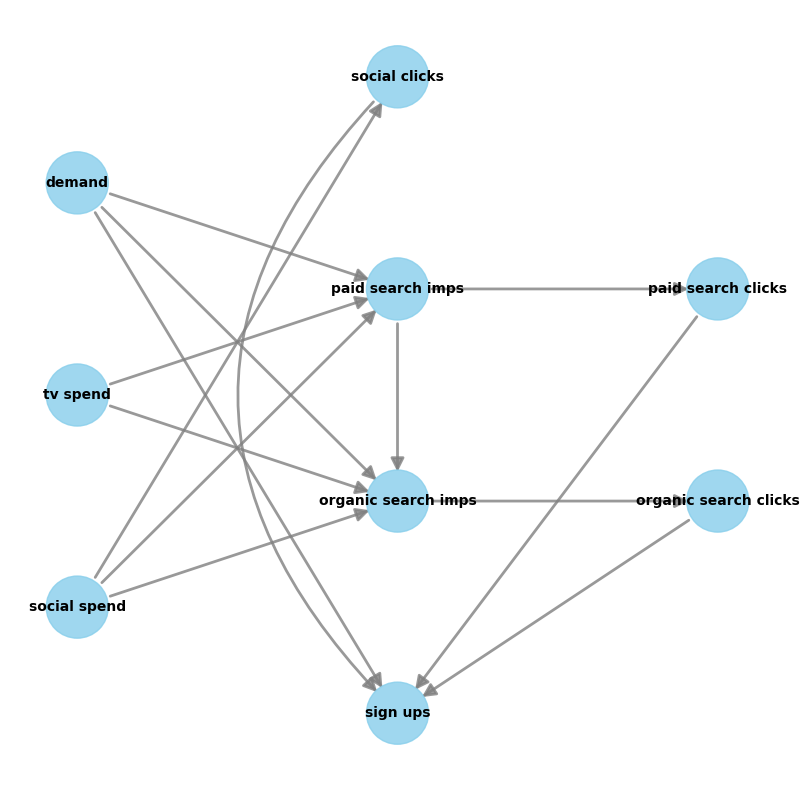

In [76]:
# Setup graph
graph = nx.from_numpy_array(graph_actual, create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, node_lookup)
gcm.util.plot(graph, figure_size=(10, 10))

In [77]:
# Create data behind graph
df = pd.DataFrame(columns=node_lookup.values())
df['demand'] = np.random.normal(loc=0, scale=1, size=1000)
df['tv spend'] = (10 * df['demand']) + np.random.normal(loc=0, scale=1, size=1000)
df['social spend'] = (5 * df['demand']) + np.random.normal(loc=0, scale=1, size=1000)
df['social clicks'] = (df['social spend'] * 0.20) + np.random.normal(loc=0, scale=1, size=1000)
df['paid search imps'] = (7 * df['demand']) + np.random.normal(loc=0, scale=1, size=1000) + (df['social spend'] * 0.10) + (df['tv spend'] * 0.15)
df['paid search clicks'] = (df['paid search imps'] * 0.50) + np.random.normal(loc=0, scale=1, size=1000)
df['organic search imps'] = (12 * df['demand']) + np.random.normal(loc=0, scale=1, size=1000) + (df['social spend'] * 0.10) + (df['tv spend'] * 0.15) - (df['paid search imps'] * 0.80)
df['organic search clicks'] = (df['paid search imps'] * 0.45) + np.random.normal(loc=0, scale=1, size=1000)
df['sign ups'] = (df['demand'] * 0.40) + np.random.normal(loc=0, scale=1, size=1000) + (df['social clicks'] * 0.10) + (df['paid search clicks'] * 0.30) + (df['organic search clicks'] * 0.30)

In [78]:
# Create SCM
causal_model = gcm.InvertibleStructuralCausalModel(graph)

causal_model.set_causal_mechanism('demand', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('tv spend', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('social spend', gcm.EmpiricalDistribution())

causal_model.set_causal_mechanism('social clicks', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('paid search imps', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('paid search clicks', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('organic search imps', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('organic search clicks', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('sign ups', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model, df)

Fitting causal mechanism of node sign ups: 100%|██████████| 9/9 [00:00<00:00, 371.26it/s]    


In [79]:
# Arrow strengths
gcm.arrow_strength(causal_model, target_node='sign ups')

{('demand', 'sign ups'): 0.050730153508495676,
 ('organic search clicks', 'sign ups'): 1.2203587868891768,
 ('paid search clicks', 'sign ups'): 1.8439670254876441,
 ('social clicks', 'sign ups'): 0.018029868352330062}

In [80]:
# Arrow strengths
gcm.arrow_strength(causal_model, target_node='paid search imps')

{('demand', 'paid search imps'): 47.13551673536306,
 ('social spend', 'paid search imps'): 0.030798438661166903,
 ('tv spend', 'paid search imps'): 4.204062952081454}

In [81]:
# Arrow strengths
gcm.arrow_strength(causal_model, target_node='organic search imps')

{('demand', 'organic search imps'): 154.49818049006538,
 ('paid search imps', 'organic search imps'): 38.12561213340997,
 ('social spend', 'organic search imps'): 0.19830006797925356,
 ('tv spend', 'organic search imps'): 2.7522213974158265}

In [82]:
# Attributions
shapley = gcm.intrinsic_causal_influence(causal_model, target_node='sign ups')


def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: round(abs(v) / total_absolute_sum * 100, 1) for k, v in value_dictionary.items()}

convert_to_percentage(shapley)

Estimating Shapley Values. Average change of Shapley values in run 23 (115 evaluated permutations): 0.7203812561247938%: 100%|██████████| 1/1 [00:24<00:00, 24.91s/it]


{'demand': 78.8,
 'tv spend': 2.0,
 'social spend': 0.5,
 'social clicks': 0.3,
 'paid search imps': 0.0,
 'paid search clicks': 2.2,
 'organic search imps': 0.1,
 'organic search clicks': 1.9,
 'sign ups': 14.2}

In [86]:
# Set graph for MMM

# Create adjacency matrix - this is the basis for our known graph
graph_actual_mmm = np.zeros((total_nodes, total_nodes))

# Create known graph using expert domain knowledge
graph_actual_mmm[0, 8] = 1.0 # demand -> signups
graph_actual_mmm[1, 8] = 1.0 # tv spend -> signups
graph_actual_mmm[2, 8] = 1.0 # social spend -> signups
graph_actual_mmm[3, 8] = 1.0 # social clicks -> signups
graph_actual_mmm[4, 8] = 1.0 # paid search imps -> signups
graph_actual_mmm[5, 8] = 1.0 # paid search clicks -> signups
graph_actual_mmm[6, 8] = 1.0 # organic search imps -> signups
graph_actual_mmm[7, 8] = 1.0 # organic search clicks -> signups

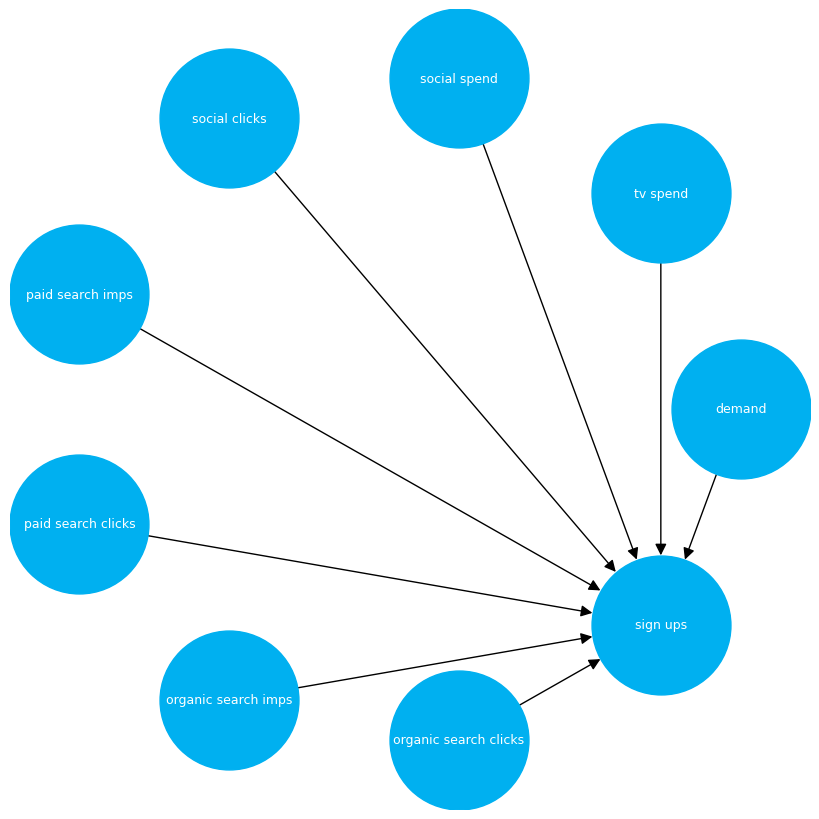

In [87]:
plot_graph(graph_actual_mmm)

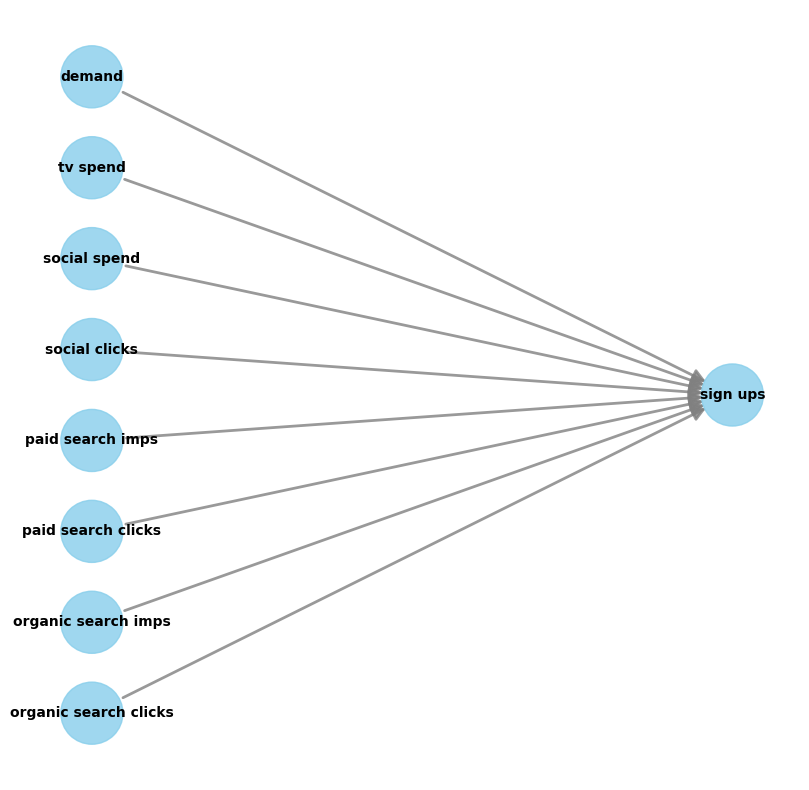

In [90]:
# Setup graph
graph_mmm = nx.from_numpy_array(graph_actual_mmm, create_using=nx.DiGraph)
graph_mmm = nx.relabel_nodes(graph_mmm, node_lookup)
gcm.util.plot(graph_mmm, figure_size=(10, 10))

In [91]:
# Create SCM
causal_model_mmm = gcm.InvertibleStructuralCausalModel(graph_mmm)

causal_model_mmm.set_causal_mechanism('demand', gcm.EmpiricalDistribution())
causal_model_mmm.set_causal_mechanism('tv spend', gcm.EmpiricalDistribution())
causal_model_mmm.set_causal_mechanism('social spend', gcm.EmpiricalDistribution())
causal_model_mmm.set_causal_mechanism('social clicks', gcm.EmpiricalDistribution())
causal_model_mmm.set_causal_mechanism('paid search imps', gcm.EmpiricalDistribution())
causal_model_mmm.set_causal_mechanism('paid search clicks', gcm.EmpiricalDistribution())
causal_model_mmm.set_causal_mechanism('organic search imps', gcm.EmpiricalDistribution())
causal_model_mmm.set_causal_mechanism('organic search clicks', gcm.EmpiricalDistribution())

causal_model_mmm.set_causal_mechanism('sign ups', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model_mmm, df)

Fitting causal mechanism of node sign ups: 100%|██████████| 9/9 [00:00<00:00, 1078.66it/s]   


In [93]:
# Arrow strengths
gcm.arrow_strength(causal_model_mmm, target_node='sign ups')

{('demand', 'sign ups'): 0.462217060565486,
 ('organic search clicks', 'sign ups'): 1.1525111727054247,
 ('organic search imps', 'sign ups'): 0.010219744451554118,
 ('paid search clicks', 'sign ups'): 2.7850186168663202,
 ('paid search imps', 'sign ups'): 0.23009577492668426,
 ('social clicks', 'sign ups'): 0.03625088137543338,
 ('social spend', 'sign ups'): 0.12657798805403286,
 ('tv spend', 'sign ups'): 0.13818247931536068}

In [94]:
# Attributions
shapley_mmm = gcm.intrinsic_causal_influence(causal_model_mmm, target_node='sign ups')


def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: round(abs(v) / total_absolute_sum * 100, 1) for k, v in value_dictionary.items()}

convert_to_percentage(shapley_mmm)

Estimating Shapley Values. Average change of Shapley values in run 11 (55 evaluated permutations): 0.4761908630969468%: 100%|██████████| 1/1 [00:16<00:00, 16.28s/it]


{'demand': 8.2,
 'tv spend': 2.2,
 'social spend': 2.9,
 'social clicks': 0.6,
 'paid search imps': 4.6,
 'paid search clicks': 45.4,
 'organic search imps': 0.0,
 'organic search clicks': 19.1,
 'sign ups': 16.9}

In [ ]:
# do the neg effect of paid search in a different notebook
# check fit statistics
# simplify graph
# make simulated data more realistic
# should we calculate counterfactuals to work out contribution